In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


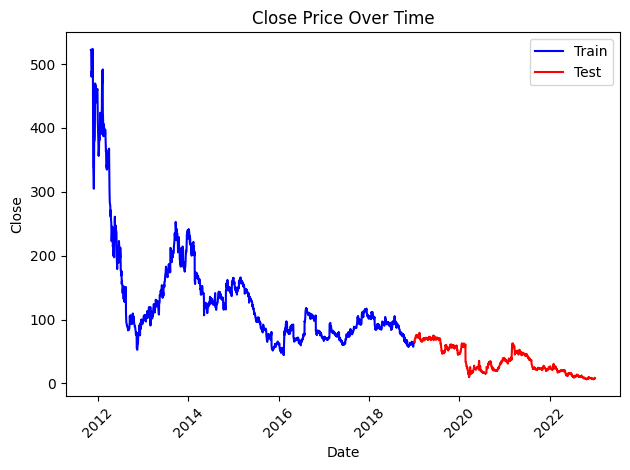

In [2]:
#GROUPON 
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
data = Data('GRPN',start_date,end_date,2019)
data.data_preprocess()

In [3]:
start_price = data.test_data.iloc[0]['close']
end_price = data.test_data.iloc[-1]['close']
total_return = (end_price - start_price) / start_price * 1

print("Buy and Hold Strategy:")
print(f"Start Price: ${start_price:.2f}")
print(f"End Price: ${end_price:.2f}")
print(f"Total Return: {total_return:.2f}")


Buy and Hold Strategy:
Start Price: $65.20
End Price: $8.58
Total Return: -0.87


Running ring
GENERATION 0 START
Generation 0: Best fitness = 0.21124439741909706 Average Fitness = 0.16023718348629173
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 0.21865683594831026 Average Fitness = 0.18144970937924523
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 0.2494516953756273 Average Fitness = 0.1846921383974849
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 0.2494516953756273 Average Fitness = 0.1927772825775247
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 0.25542440106797915 Average Fitness = 0.20142211409117414
GENERATION 4 END
Running ring
GENERATION 0 START
Generation 0: Best fitness = 0.2811602923454909 Average Fitness = 0.16181000854927846
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 0.33905918618674646 Average Fitness = 0.18400642824166896
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 0.3590976734654532 Average Fitness = 0.20015381180960057
GENERATION 2 

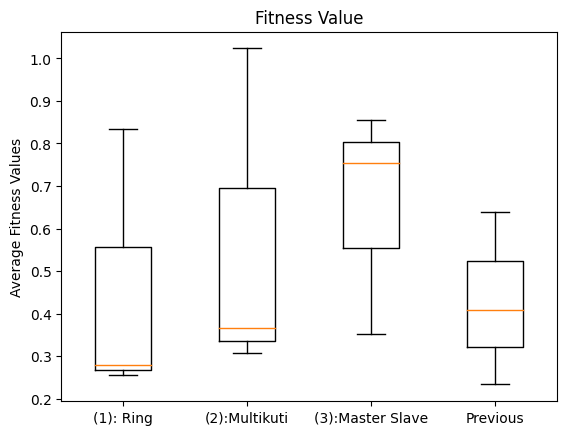

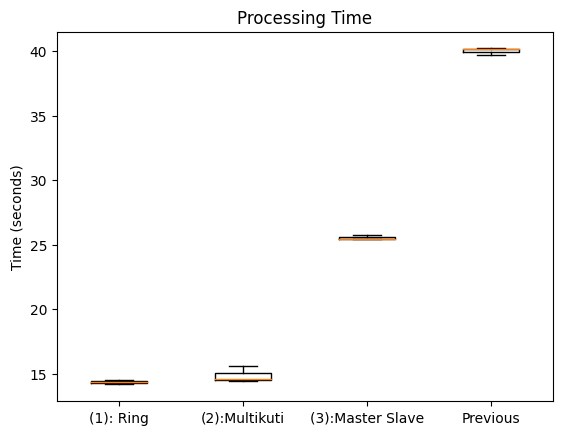

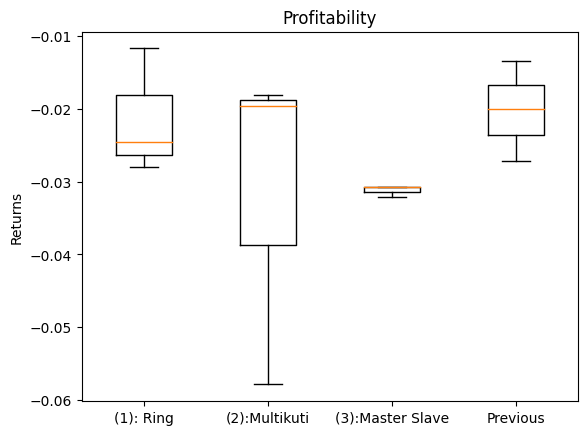

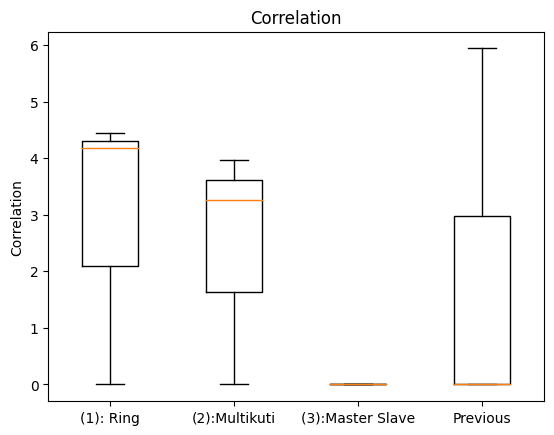

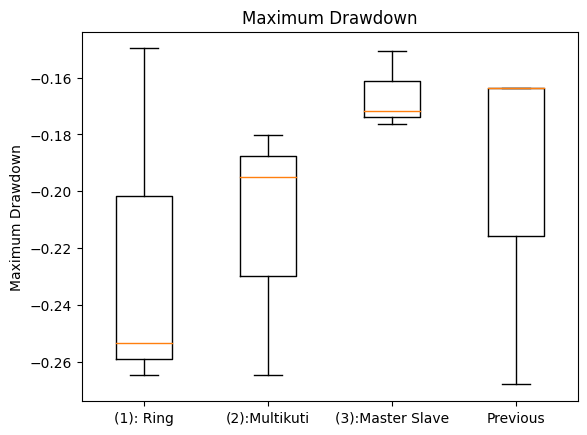

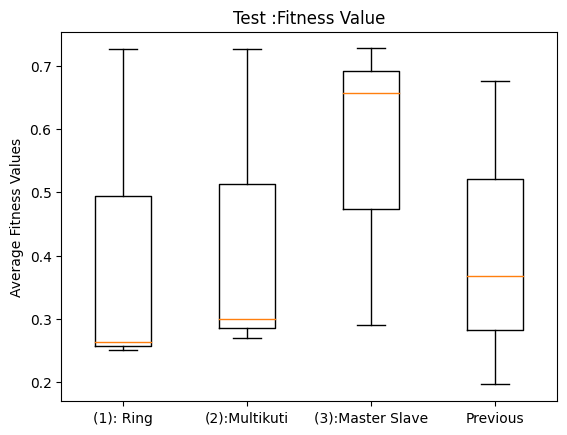

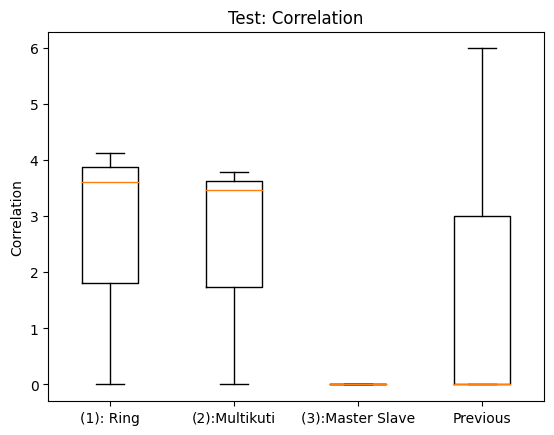

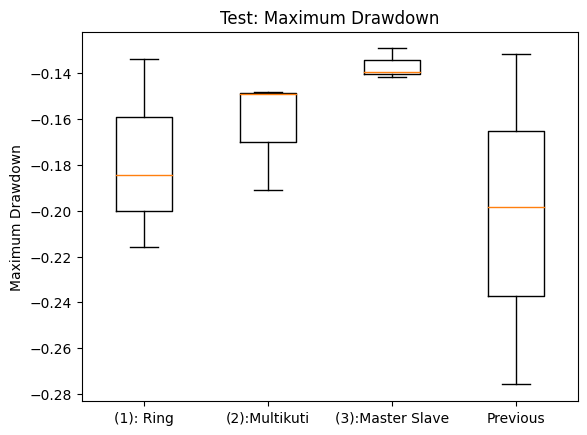

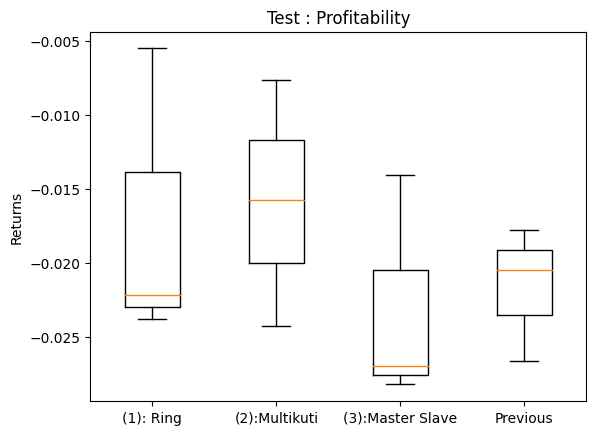

In [5]:
#total return training 
import matplotlib.pyplot as plt

fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
speed_values =  {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
risk = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
mdd = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_risk = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_mdd = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
evolve_strategy =["ring", "multikuti","master_slave","gga"]

for i in evolve_strategy:
    for j in range(3):
        start = time.time()
        ga = IslandGGA(data=data.train_data,num_islands=8,m_iter=15,num_iter=5,pSize=50,r_cross=0.4,r_mut=0.1,strategies=data.strategies,evolve_strategy=i)
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        ### USE TRAIN DATA? 
        fitness_values[i].append(ga.globalBest.fitness_value)
        profit[i].append(ga.globalBest.profit)
        risk[i].append(ga.globalBest.corr)
        mdd[i].append(ga.globalBest.mdd)
        ### USE TEST DATA HERE? 
        ga.globalBest.calculate_chromosome_fitness(data.test_data,1)
        test_fitness_values[i].append(ga.globalBest.fitness_value)
        test_profit[i].append(ga.globalBest.profit)
        test_risk[i].append(ga.globalBest.corr)
        test_mdd[i].append(ga.globalBest.mdd)



# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  evolve_strategy]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Average Fitness Values')

# Set the title of the plot
ax.set_title('Fitness Value')

# Show the plot
plt.show()



#### TIME PLOT
# Combine the time data into a list
speed_data = [speed_values[i] for i in  evolve_strategy]

# Create a time box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Time (seconds)')

# Set the title of the plot
ax.set_title('Processing Time')

# Show the plot
plt.show()



#### profit
# Combine the profit data into a list
profit_data = [profit[i] for i in  evolve_strategy]

# Create a profit box plot
fig, ax = plt.subplots()
ax.boxplot(profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Returns')

# Set the title of the plot
ax.set_title('Profitability')

# Show the plot
plt.show()



#### risk
# Combine the risk data into a list
risk_data = [risk[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(risk_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Correlation')

# Set the title of the plot
ax.set_title('Correlation')

# Show the plot
plt.show()

#### mdd
# Combine the risk data into a list
mdd_data = [mdd[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(mdd_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Maximum Drawdown')

# Set the title of the plot
ax.set_title('Maximum Drawdown')

# Show the plot
plt.show()


# Combine the test fitness data into a list
test_fitness_data = [test_fitness_values[i] for i in  evolve_strategy]
# Create a test fitness box plot
fig, ax = plt.subplots()
ax.boxplot(test_fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Average Fitness Values')

# Set the title of the plot
ax.set_title('Test :Fitness Value')
# Show the plot
plt.show()

#### test risk
# Combine the risk data into a list
test_risk_data = [test_risk[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(test_risk_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Correlation')

# Set the title of the plot
ax.set_title('Test: Correlation')

#### test mdd
# Combine the risk data into a list
test_mdd_data = [test_mdd[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(test_mdd_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Maximum Drawdown')

# Set the title of the plot
ax.set_title('Test: Maximum Drawdown')

#### profit
# Combine the profit data into a list
test_profit_data = [test_profit[i] for i in  evolve_strategy]

# Create a test profit box plot
fig, ax = plt.subplots()
ax.boxplot(test_profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Returns')

# Set the title of the plot
ax.set_title('Test : Profitability')

# Show the plot
plt.show()

In [26]:
df = pd.DataFrame(test_profit_data).T
df.columns = evolve_strategy
df.describe()

,ring,multikuti,master_slave,gga
count,3.000000,3.000000,3.000000,3.000000
mean,-0.017172,-0.015877,-0.023097,-0.021629
std,0.010138,0.008303,0.007830,0.004539
min,-0.023820,-0.024254,-0.028241,-0.026632
25%,-0.023006,-0.019991,-0.027602,-0.023556
50%,-0.022193,-0.015728,-0.026964,-0.020479
75%,-0.013848,-0.011689,-0.020525,-0.019128
max,-0.005503,-0.007649,-0.014086,-0.017776


In [2]:
#1736 mins